In [1]:
import pandas as pd


ab_path = "~/A_B_test/ecommerce_ab_testing_2022_dataset1/ab_data.csv" 
country_path = "~/A_B_test/ecommerce_ab_testing_2022_dataset1/countries.csv" 
df = pd.read_csv(ab_path)
countries = pd.read_csv(country_path)



In [2]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


## Cleaning_ab_test_file

In [5]:
# check wether there are duplicate user_id
df.duplicated(subset='user_id').sum()

3895

In [6]:
# clean dup_id, leave the first record
df_clean = df.drop_duplicates(subset='user_id', keep='first')

print(df_clean.info())
print("after cleaning：", df_clean.shape[0])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
None
after cleaning： 290585


In [7]:
## check group vs landing_page is matched
#treatment - new,control - old
df_clean.groupby('group')['landing_page'].value_counts()

group      landing_page
control    old_page        144226
           new_page          1006
treatment  new_page        144315
           old_page          1038
Name: landing_page, dtype: int64

In [8]:
df_clean = df_clean[((df_clean['group'] == 'control') & (df_clean['landing_page'] == 'old_page')) |
                    ((df_clean['group'] == 'treatment') & (df_clean['landing_page'] == 'new_page'))]


print(df_clean.groupby('group')['landing_page'].value_counts())
print("after 2nd cleaning：", df_clean.shape[0])

group      landing_page
control    old_page        144226
treatment  new_page        144315
Name: landing_page, dtype: int64
after 2nd cleaning： 288541


In [9]:
control_conversion = df_clean[df_clean['group'] == 'control']['converted'].mean()
treatment_conversion = df_clean[df_clean['group'] == 'treatment']['converted'].mean()

print(f"control_conversion: {control_conversion:.4f}")
print(f"treatment_conversion: {treatment_conversion:.4f}")

control_conversion: 0.1203
treatment_conversion: 0.1187


## **Statistical Significance Test (Z-Test)**
use a **Z-Test** to calculate the **p-value**:

- **Null Hypothesis (H₀)**: The conversion rate of the new page **equals** the conversion rate of the old page (no difference).  
- **Alternative Hypothesis (H₁)**: The conversion rate of the new page **is different** from the conversion rate of the old page (there is a significant difference).  
- **If p-value < 0.05** → The difference in conversion rates is **statistically significant**.  
- **If p-value ≥ 0.05** → The difference in conversion rates is **not statistically significant** (it could be due to random variation).  
reason: samples> 30 and binomial distribution

In [10]:
#pip install statsmodels

In [11]:
from statsmodels.stats.proportion import proportions_ztest

# success user
control_success = df_clean[df_clean['group'] == 'control']['converted'].sum()
treatment_success = df_clean[df_clean['group'] == 'treatment']['converted'].sum()

control_size = df_clean[df_clean['group'] == 'control'].shape[0]
treatment_size = df_clean[df_clean['group'] == 'treatment'].shape[0]

# z test
z_stat, p_value = proportions_ztest([treatment_success, control_success], [treatment_size, control_size])


print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")


Z-statistic: -1.2949
P-value: 0.1953


 ### there is no statistically significant difference between the conversion rates of the new and old pages

# Apply logistic regression, add more features 

In [12]:
import statsmodels.api as sm

# X: only select group
df_clean['group_numeric'] = df_clean['group'].apply(lambda x: 1 if x == 'treatment' else 0)
X = df_clean[['group_numeric']]
X = sm.add_constant(X)  

# Y
y = df_clean['converted']

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())
#p value 0.195 same as ABtest

Optimization terminated successfully.
         Current function value: 0.365941
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               288541
Model:                          Logit   Df Residuals:                   288539
Method:                           MLE   Df Model:                            1
Date:                Wed, 19 Mar 2025   Pseudo R-squ.:               7.940e-06
Time:                        16:48:10   Log-Likelihood:            -1.0559e+05
converged:                       True   LL-Null:                   -1.0559e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1953
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.9897      0.008   -245.805      0.000      -2.006      -1.974
group_numeric    -0.

In [13]:
# merge country

df_clean = df_clean.merge(countries, on="user_id", how="left")  
#df_clean = df_clean.drop(columns=[col for col in df_clean.columns if "country_" in col], errors="ignore")

df_clean

,user_id,timestamp,group,landing_page,converted,group_numeric,country
0,851104,11:48.6,control,old_page,0,0,US
1,804228,01:45.2,control,old_page,0,0,US
2,661590,55:06.2,treatment,new_page,0,1,US
3,853541,28:03.1,treatment,new_page,0,1,US
4,864975,52:26.2,control,old_page,1,0,US
...,...,...,...,...,...,...,...
288537,945152,51:57.1,control,old_page,0,0,US
288538,734608,45:03.4,control,old_page,0,0,US
288539,697314,20:29.0,control,old_page,0,0,US
288540,715931,40:24.5,treatment,new_page,0,1,UK


In [14]:

# add new feature"country"
unique_countries = df_clean['country'].unique()
print("Unique countries:", unique_countries)
print("Total number of unique countries:", len(unique_countries))


Unique countries: ['US' 'CA' 'UK']
Total number of unique countries: 3


In [15]:
# one-hot encoding(change countries name to a single code num)
df_clean = pd.get_dummies(df_clean, columns=['country'], drop_first=True)
#to aviod Multicollinearity, drop Country_CA, if country_UK is +, conversion rate higher than CA


In [17]:
print(df_clean.columns)


Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted',
       'group_numeric', 'country_UK', 'country_US'],
      dtype='object')


In [16]:
df_clean

,user_id,timestamp,group,landing_page,converted,group_numeric,country_UK,country_US
0,851104,11:48.6,control,old_page,0,0,0,1
1,804228,01:45.2,control,old_page,0,0,0,1
2,661590,55:06.2,treatment,new_page,0,1,0,1
3,853541,28:03.1,treatment,new_page,0,1,0,1
4,864975,52:26.2,control,old_page,1,0,0,1
...,...,...,...,...,...,...,...,...
288537,945152,51:57.1,control,old_page,0,0,0,1
288538,734608,45:03.4,control,old_page,0,0,0,1
288539,697314,20:29.0,control,old_page,0,0,0,1
288540,715931,40:24.5,treatment,new_page,0,1,1,0


In [18]:
# Logistics regression
# X group_numeric + country
X = df_clean[['group_numeric'] + [col for col in df_clean.columns if 'country_' in col]]
X = sm.add_constant(X)  

# y
y = df_clean['converted']


logit_model_adv = sm.Logit(y, X).fit()
#print(logit_model_adv.summary())
print(logit_model_adv.summary2(float_format="%.6f"))


Optimization terminated successfully.
         Current function value: 0.365935
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              211183.0327
Date:               2025-03-19 16:49 BIC:              211225.3231
No. Observations:   288542           Log-Likelihood:   -1.0559e+05
Df Model:           3                LL-Null:          -1.0559e+05
Df Residuals:       288538           LLR p-value:      0.18417    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -2.0307   0.0267 -75.9752 0.0000 -2.0831 -1.9783
group_numeric     -0.0148   0.0115  -1.2913 0.1966 -0

for group_numeric:
p-value > 0.05, the new page does not significantly impact conversion rates.
No clear improvement or decline, likely due to random variation

UK (p = 0.0775): Slightly higher conversion rate than the baseline, but not statistically significant.
US (p = 0.1332): No significant difference compared to the baseline.

with feature group_num & country the conversion rate is not influenced in statistics saying.

## Add one more feature Time spend

In [24]:

print(df_clean['timestamp'].head())  
print(df_clean['timestamp'].dtype)

0    11:48.6
1    01:45.2
2    55:06.2
3    28:03.1
4    52:26.2
Name: timestamp, dtype: object
object


In [25]:
def convert_to_seconds(time_str):
    parts = time_str.split(":")  # ["hh", "mm.ss"] / ["mm", "ss"]
    
    if len(parts) == 3: 
        hours, minutes, seconds = int(parts[0]), int(parts[1]), float(parts[2])
    elif len(parts) == 2:  
        hours, minutes, seconds = 0, int(parts[0]), float(parts[1])
    else:
        return None  

    return hours * 3600 + minutes * 60 + seconds  # to second

df_clean['time_spent'] = df_clean['timestamp'].astype(str).apply(convert_to_seconds)

print(df_clean[['timestamp', 'time_spent']].head())


  timestamp  time_spent
0   11:48.6       708.6
1   01:45.2       105.2
2   55:06.2      3306.2
3   28:03.1      1683.1
4   52:26.2      3146.2


In [27]:
df_clean

,user_id,timestamp,group,landing_page,converted,group_numeric,country_UK,country_US,time_spent
0,851104,11:48.6,control,old_page,0,0,0,1,708.6
1,804228,01:45.2,control,old_page,0,0,0,1,105.2
2,661590,55:06.2,treatment,new_page,0,1,0,1,3306.2
3,853541,28:03.1,treatment,new_page,0,1,0,1,1683.1
4,864975,52:26.2,control,old_page,1,0,0,1,3146.2
...,...,...,...,...,...,...,...,...,...
288537,945152,51:57.1,control,old_page,0,0,0,1,3117.1
288538,734608,45:03.4,control,old_page,0,0,0,1,2703.4
288539,697314,20:29.0,control,old_page,0,0,0,1,1229.0
288540,715931,40:24.5,treatment,new_page,0,1,1,0,2424.5


In [28]:
X = df_clean[['group_numeric', 'country_UK', 'country_US', 'time_spent']]
X = sm.add_constant(X)  

#y
y = df_clean['converted']

logit_model_time = sm.Logit(y, X).fit()
print(logit_model_time.summary2(float_format="%.6f"))

Optimization terminated successfully.
         Current function value: 0.365934
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              211184.6460
Date:               2025-03-19 17:25 BIC:              211237.5090
No. Observations:   288542           Log-Likelihood:   -1.0559e+05
Df Model:           4                LL-Null:          -1.0559e+05
Df Residuals:       288537           LLR p-value:      0.26515    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
const             -2.0245   0.0285 -70.9395 0.0000 -2.0804 -1.9685
group_numeric     -0.0148   0.0115  -1.2923 0.1962 -0

p value for time spent is 0.534 >> 0.05 there is no significant influence on conversion rate

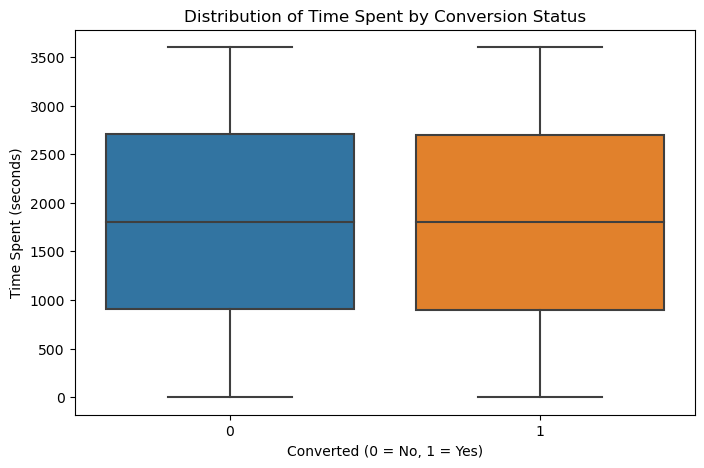

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x=df_clean['converted'], y=df_clean['time_spent'])
plt.xlabel("Converted (0 = No, 1 = Yes)")
plt.ylabel("Time Spent (seconds)")
plt.title("Distribution of Time Spent by Conversion Status")
plt.show()

In [33]:
#try other algorithms Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# X,Y independent&dependent variable
X = df_clean[['group_numeric', 'country_UK', 'country_US', 'time_spent']]
y = df_clean['converted']

# training & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, class_weight = 'balanced',random_state=42)
rf_model.fit(X_train, y_train)

#prediction
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7379611499072934
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.85     50759
           1       0.12      0.18      0.14      6950

    accuracy                           0.74     57709
   macro avg       0.50      0.50      0.49     57709
weighted avg       0.79      0.74      0.76     57709



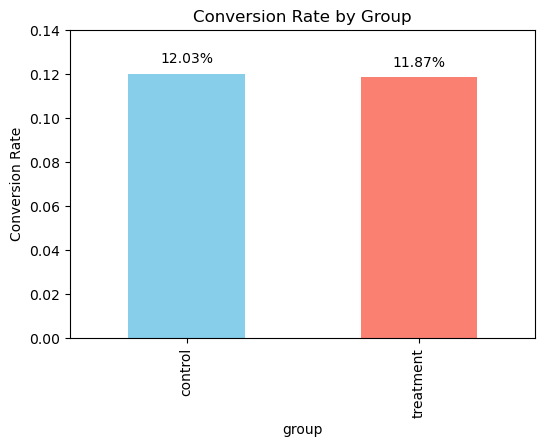

In [19]:
#visualization


conversion_rates = df_clean.groupby('group')['converted'].mean()

# barplot
plt.figure(figsize=(6,4))
conversion_rates.plot(kind='bar', color=['skyblue','salmon'])
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Group")
plt.ylim(0, max(conversion_rates) + 0.02)

for i, v in enumerate(conversion_rates):
    plt.text(i, v + 0.005, f"{v:.2%}", ha='center')

plt.show()


## Final Conclusion & Business Recommendations
#### 1.The A/B test results do not support the full rollout of the new page, as there is no significant impact on conversion rates.
#### 2.Country and time spent have no significant effect on conversion.

#### 3.Current variables are insufficient to predict conversions, and machine learning models do not significantly improve predictive power.